## Scraping Zillow.com to analyze housing price in New York City 

My goal here is to collect housing prices for both rental and sale in New York city. I looked at three major real estate website including Trulia, Zillow, and StreetEasy. Comparing to the other two websites, StreetEasy gives the most information on the searching results page and the format of each listing is very consistent, which is great for the purpose of web-scraping.<br\ >
<a href="http://zillow.com/">
<img "StreetEasy" src="map/streetEasy_logo.jpg" height="30px" width="150px"/></a><br\ >

Web scraping is done using the beautifulsoup package in Python. I created two functions that can loop through all the pages of searching results, and also empty strings to store results. Below are the steps I took to scrape StreetEasy:
1. Analyzing the HTML page: HTML code of a web page can be viewed by right click and selecting 'Inspect'. This helps us identifying the HTML tags of the information to be scraped
2. Making the soup!: It is important to select the correct parser for your data type. I used HTML parser.
3. Navigating the parse tree and iterate through tags: once the soup is made, we have the HTML code in Python. We can then find our desired information by searching through HTML tags.

In [ ]:
import os
import time
import sys
import numpy as np
import pandas as pd
import regex as re
import lxml
import numbers
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent
import random
from ratelimit import limits, sleep_and_retry
from datetime import datetime

In [ ]:
req_headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-encoding': 'gzip, deflate, br',
    'Accept-language': 'en-US,en;q=0.8',
    'Upgrade-insecure-requests': '1',
    'User-agent': UserAgent().random,
}

base_url = "https://streeteasy.com/for-sale/"
#base_url = "https://www.zillow.com/homes/for_sale/"
urls = []

city = 'nyc'
url1 = base_url +city+'/'
urls.append(url1)

start_page = 2
end_page = 3

# Add all pages
for i in range(start_page, end_page + 1):
    dom = base_url + city + '/' + 'page_' + str(i) #streeteasy
    #dom = base_url + city + '/' + str(i) '_p' +'/' #zillow
    if dom not in urls:
        urls.append(dom)

print(urls)

#https://streeteasy.com/for-sale/nyc/price:-400000?page=2 with max
#https://streeteasy.com/for-sale/nyc/price:100000-700000 min and max
#https://streeteasy.com/for-rent/nyc/price:-12500 for rent
#https://streeteasy.com/for-rent/nyc/page_2 for rent

# Define the rate limit: e.g., 5 calls per 60 seconds
@sleep_and_retry
@limits(calls=5, period=60)
def soups(data):
    with requests.Session() as s:
        r = s.get(data, headers=req_headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        #print(soup.prettify())  # Corrected line: Print prettified HTML content from the soup object
    return soup


#for url in urls:
#    htmls=soups(url)
# Call soup function and store output in a list
#lst = []

#for url in urls:
#    htmls = soups(url)

#print(len(urls))

Fetches and saves prettify data from rental site

In [5]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from ratelimit import limits, sleep_and_retry


@sleep_and_retry
@limits(calls=5, period=60)
def get_page_content(url,headers):
    """
    Function to get the HTML content of a webpage given its URL.
    """
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for 4xx or 5xx status codes
        return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching page content: {e}")
        return None

def write_content_to_file(content, filename):
    """
    Function to write content to a file.
    """
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(content)

def main():
    # Define the base URL and the number of pages you want to scrape
    #base_url = "https://zillow.com/new-york-ny/rentals"
    #base_url = "https://zillow.com/new-york-ny/sales"
    #base_url = "https://zillow.com/new-york-ny/sold"
    #base_url = "http://streeteasy.com/for-sale/nyc?" #1272 
    base_url = "http://streeteasy.com/for-rent/nyc?" #1392
    num_pages = 1392  # Number of additional pages to scrape
    start_page = 1  # Starting page number
    headers = {
        'User-Agent': UserAgent().random,
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'Connection': 'keep-alive',
        'Referer': 'https://google.com',
        'Pragma': 'no-cache',
        'Cache-Control': 'no-cache'
    }

    # Request and parse content for each page
    for page_number in range(start_page, num_pages + 1):
        #full_url = f"{base_url}/{page_number}_p/" Zillow        
        full_url = f"{base_url}page={page_number}" # Streeteasy
        print(f"Fetching content from: {full_url}")
        page_content = get_page_content(full_url, headers)
        if page_content:
            # Write content to a file
            #filename = f"Page_{page_number}.html"  # Create a filename based on the page number
            #print(f"Page {page_number} content fetched successfully.")
           # write_content_to_file(page_content, filename)
           # print(f"Prettified content written to: {filename}")

             # Parse content using BeautifulSoup and prettify
            soup = BeautifulSoup(page_content, 'html.parser')
            prettified_content = soup.prettify()
            
            # Write content to a file
            prettyFilename = f"pretty_page_{page_number}.html"  # Create a filename based on the page number
            write_content_to_file(prettified_content, prettyFilename)
            print(f"Prettified content written to: {prettyFilename}")
        else:
            print(f"No content found for: {full_url}")
        print("=" * 50)  # Separator for better readability

if __name__ == "__main__":
    main()

Fetching content from: http://streeteasy.com/for-rent/nyc?page=1
Error fetching page content: 403 Client Error: Forbidden for url: https://streeteasy.com/for-rent/nyc?page=1
No content found for: http://streeteasy.com/for-rent/nyc?page=1
Fetching content from: http://streeteasy.com/for-rent/nyc?page=2
Error fetching page content: 403 Client Error: Forbidden for url: https://streeteasy.com/for-rent/nyc?page=2
No content found for: http://streeteasy.com/for-rent/nyc?page=2
Fetching content from: http://streeteasy.com/for-rent/nyc?page=3
Error fetching page content: 403 Client Error: Forbidden for url: https://streeteasy.com/for-rent/nyc?page=3
No content found for: http://streeteasy.com/for-rent/nyc?page=3
Fetching content from: http://streeteasy.com/for-rent/nyc?page=4
Error fetching page content: 403 Client Error: Forbidden for url: https://streeteasy.com/for-rent/nyc?page=4
No content found for: http://streeteasy.com/for-rent/nyc?page=4
Fetching content from: http://streeteasy.com/for

KeyboardInterrupt: 

In [ ]:
import math

rate_limit = 5 #calls/pages per minute
period = 60 #a period of 60 seconds

def estimate_time(rate_limit, period):
    time_needed = pages / rate_limit #pages/5calls/minute
    minutes = math.floor(time_needed)
    seconds = math.ceil((time_needed - minutes) * 60)
    return minutes, seconds

# Example usage:
pages = 98

minutes, seconds = estimate_time(pages, rate_limit)
print(f"Estimated time needed: {minutes} minutes and {seconds} seconds.")


In [ ]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import json

# Web URL
web_url = "https://www.zillow.com/new-york-ny/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-76.09592245507815%2C%22east%22%3A-71.8634395449219%2C%22south%22%3A40.120647691241565%2C%22north%22%3A41.27009728054556%7D%2C%22usersSearchTerm%22%3A%22New%20York%2C%20NY%22%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A6181%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A9%7D"
# https://www.zillow.com/new-york-ny/for_sale/3_p/
# Define request headers
req_headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'Accept-encoding': 'gzip, deflate, br',
    'Accept-language': 'en-US,en;q=0.8',
    'Upgrade-insecure-requests': '1',
    'User-agent': UserAgent().random,
}


# Get URL Content
r = requests.get(web_url, headers=req_headers)

# Parse HTML Code
soup = BeautifulSoup(r.content, 'html.parser')
all_data = soup.find_all("script", {"type": "application/ld+json"})

data = []
for ld_json in all_data:
    jsn = json.loads(ld_json.string)
    data.append(jsn)
    print(jsn)

response_content = fetch_zillow_data(url)
if response_content:
    properties = extract_json_data_property_info(response_content)
    for property in properties:
        print(property)

def extract_json_data_property_info(response_content):
    """
    Extracts property information from Zillow data.
    
    Parameters:
    - response_content (str): The content of the HTTP response containing Zillow data.
    
    Returns:
    - property_info (list): A list containing dictionaries with property information.
    """
    if response_content is None:
        return []

    property_info = []
    soup = BeautifulSoup(response_content, "html.parser")
    scripts = soup.find_all("script", {"type": "application/ld+json"})
    
    for script in scripts:
        data = json.loads(script.string)
        property_type = data.get("@type", "")
        street_address = data["address"]["streetAddress"] if "address" in data else ""
        locality = data["address"]["addressLocality"] if "address" in data else ""
        region = data["address"]["addressRegion"] if "address" in data else ""
        postal_code = data["address"]["postalCode"] if "address" in data else ""
        floor_size = data["floorSize"]["value"] if "floorSize" in data else ""
        latitude = data["geo"]["latitude"] if "geo" in data else ""
        longitude = data["geo"]["longitude"] if "geo" in data else ""
        url = data.get("url", "")
        
        property_info.append({
            "property_type": property_type,
            "floor_size": floor_size,
            "street_address": street_address,
            "locality": locality,
            "region": region,
            "postal_code": postal_code,
            "latitude": latitude,
            "longitude": longitude,
            "url": url
        })

    return property_info


#print(soup.prettify())


In [ ]:
# Initialize a list to store listing information
def parse_soup(soup):
    listings = []

    # Find all listing cards on the page
    listing_cards = soup.find_all(class_="listingCard")

    for card in listing_cards:
        # Iterate through each listing card and extract relevant information
            # Extract building type and neighborhood
        building_info = card.find(class_="listingCardLabel")
        building_type_neighborhood = building_info.text.strip()

        # Extract address
        address = card.find('address', class_='listingCard-addressLabel listingCard-upperShortLabel').get_text().strip()

        # Extract price
        price = card.find('span', class_='price listingCard-priceMargin').get_text().strip()

        # Extract bed, bathroom details, and size
        description = card.find('div', class_='description').text
        bedrooms = card.find('div', class_='bedrooms').text
        bathrooms = card.find('div', class_='bathrooms').text
        size = card.find('div', class_='size').text

        # Extract amenities match
        amenities_list = card.find('ul', class_='amenities').find_all('li')
        amenities = [amenity.text for amenity in amenities_list]

        # property url
        url = card.find('a', class_='listingCard-link jsCardLinkGA featured-link-to-hdp')['href']

        # Create a dictionary to store the extracted information
        extracted_listings = {
            "address": address,
             "building_type_neighborhood": building_type_neighborhood,
            "size (sq. ft.)": size,
            "price": price,
            "# bedrooms": bedrooms,
            "# bathrooms": bathrooms,
            "amenities": amenities,
            "description": description,
            "url": url
        
        }
        # Append the dictionary to the list
        listings.append(extracted_listings)

    return listings

        # Append the listing dictionary to the list of listings
        
            #address = data.find_all(class_= 'list-card-addr') zillow
            #price = list(data.find_all(class_='list-card-price')) zillow
            #beds = list(data.find_all("ul", class_="list-card-details")) zillow
            #last_updated = data.find_all('div', {'class': 'list-card-top'}) zillow

        

# Example usage:
# Define the URL from which you want to fetch the HTML content
#url = "your_url_here"

# Fetch the HTML content from the URL
#soup = soups(url)

# Parse the HTML content and extract listing information from JSON-LD data
listings = parse_soup(soup)

# Create a pandas DataFrame from the extracted listing information
df = pd.DataFrame(listings)

# Print the DataFrame
print(df)

In [77]:
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import json
import pandas as pd
import os
from datetime import datetime

def fetch_zillow_data(url, cache_file):
    """
    Fetches Zillow data from the provided URL, either by fetching it from the cache or making a new request.

    Parameters:
    - url (str): The URL to fetch Zillow data from.
    - cache_file (str): The file path for caching the fetched data.

    Returns:
    - response_content (str): The content of the HTTP response containing Zillow data.
    """
    if os.path.exists(cache_file):
        with open(cache_file, 'r') as f:
            return f.read()
    else:
        headers = {
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
            'Accept-encoding': 'gzip, deflate, br',
            'Accept-language': 'en-US,en;q=0.8',
            'Upgrade-insecure-requests': '1',
            'User-agent': UserAgent().random,
        }

        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()  # Raise an exception for HTTP errors
            response_content = response.content
            with open(cache_file, 'w') as f:
                f.write(response_content.decode('utf-8'))
            return response_content
        except requests.RequestException as e:
            print(f"Error fetching data: {e}")
            return None


def extract_property_info(response_content):
    property_info = []
    """
    Extracts property information from the response content.

    Parameters:
    - response_content (str): The content of the HTTP response containing Zillow data.

    Returns:
    - property_info (list): List of dictionaries containing unique property information.
    
    if not response_content:
        print("Error: Response content is empty.")
        return []
    """
    try:
        soup = BeautifulSoup(response_content, "html.parser")
        zpid_elements = soup.find_all("script", {"type": "application/ld+json"})

        #Extracting data from the __NEXT_DATA__ script tag
        #next_data_script = soup.find("script", {"id": "__NEXT_DATA__"})
        #if next_data_script:
            #try:
                #next_data = json.loads(next_data_script.string)
                # Prettify the JSON data
                #prettified_data = json.dumps(next_data, indent=2)
                #print(prettified_data)
                # Access and process the data as needed
                # Example: data = next_data['props']['pageProps']['your_data_key']
            #except json.JSONDecodeError as e:
                #print(f"Error decoding JSON from __NEXT_DATA__: {e}")

        for script in zpid_elements:
            data = json.loads(script.string)
            url = data.get("url", "")
            zpid_parts = url.split("/")
            if len(zpid_parts) >= 2:
                zpid_str = zpid_parts[-2]
                zpid_numeric = ''.join(filter(str.isdigit, zpid_str))
                zpid = int(zpid_numeric) if zpid_numeric else 0
            else:
                zpid = 0

                property_details = {
                "zpid": zpid,
                "property_type": "",
                "price": "",
                "street_address": "",
                "locality": "",
                "region": "",
                "postal_code": "",
                "floor_size": "",
                "bedrooms": "",
                "bathrooms": "",
                "sqft": "",
                "days_on_zillow": "",
                "latitude": "",
                "longitude": "",
                "url": url,
            }
                
            # Extract property details from JSON data
            if "@type" in data:
                address_data = data.get("address", {})
                property_details["street_address"] = address_data.get("streetAddress", "")
                property_details["locality"] = address_data.get("addressLocality", "")
                property_details["region"] = address_data.get("addressRegion", "")
                property_details["postal_code"] = address_data.get("postalCode", "")

            if "floorSize" in data and not property_details["floor_size"]:
                property_details["floor_size"] = ''.join(filter(str.isdigit, data.get("floorSize", {}).get("value", "")))

            if "geo" in data:
                property_details["latitude"] = data["geo"].get("latitude", "")
                property_details["longitude"] = data["geo"].get("longitude", "")

            # Additional property details extraction if needed
            corresponding_html = soup.find("article", {"id": lambda x: x and x.startswith(f"zpid_{zpid}")})
            if corresponding_html:
                if not property_details["street_address"]:
                    address_element = corresponding_html.find("address", {"data-test": "property-card-addr"})
                    if address_element:
                        address = address_element.get_text(strip=True)
                        property_details["street_address"] = address

                if not property_details["price"]:
                    price_element = corresponding_html.find("span", {"data-test": "property-card-price"})
                    if price_element:
                        property_details["price"] = price_element.get_text(strip=True)

                ul_elements = corresponding_html.find_all("ul", class_="StyledPropertyCardHomeDetailsList-c11n-8-84-3__sc-1xvdaej-0")
                for ul in ul_elements:
                    lis = ul.find_all("li")
                    for li in lis:
                        abbr = li.find("abbr")
                        if abbr:
                            abbr_text = abbr.text.strip().lower()
                            if "bd" in abbr_text:
                                property_details["bedrooms"] = li.find("b").text.strip()
                            elif "ba" in abbr_text:
                                property_details["bathrooms"] = li.find("b").text.strip()
                            elif "sqft" in abbr_text:
                                property_details["sqft"] = li.find("b").text.strip()                                

                # Extracting property types
                div_elements = corresponding_html.find_all("div", class_="StyledPropertyCardDataArea-c11n-8-84-3__sc-yipmu-0 dbDWjx")
                for div in div_elements:
                    text_content = div.get_text().strip()            

                    # Split the text on "-" character and take the first part as the property type
                    parts = text_content.split("-")
                    if len(parts) > 1:
                        property_type = parts[0].strip()
                    else:
                        # If the text doesn't contain "-", use the entire text as the property type
                        property_type = text_content.strip()

                    # Append the extracted property type to the property_types list
                    property_details["property_type"] = property_type


                # Extracting days on Zillow
                days_on_zillow_element = corresponding_html.find("span", class_="StyledPropertyCardBadge-c11n-8-84-3__sc-6gojrl-0")
                if days_on_zillow_element:
                    property_details["days_on_zillow"] = days_on_zillow_element.text.strip()


                # Validate property details
                if property_details["zpid"] != 0 and property_details["street_address"] and property_details["price"]:
                    property_info.append(property_details)
        
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON data: {e}")
    except Exception as e:
        print(f"Error occurred during extraction: {e}")

    return property_info


#    url = f"{base_url}{page_number}_p/?searchQueryState=%7B%22pagination%22%3A%7B%22currentPage%22%3A{page_number}%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-74.92725180078128%2C%22east%22%3A-73.03211019921878%2C%22south%22%3A40.27379533285657%2C%22north%22%3A41.11922552941539%7D%2C%22mapZoom%22%3A9%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A6181%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22fr%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%7D"


#dfs = []  # List to store DataFrames

def main():
    rental_base_url = "https://www.zillow.com/new-york-ny/rentals/"
    sales_base_url = "https://www.zillow.com/new-york-ny/sales/"
    urls = []

    pages_to_fetch = 2  # Adjust the number of pages to fetch

    for i in range(1, pages_to_fetch + 1):
        if i == 1:
           urls.append(rental_base_url) #for rentals
            #urls.append(sales_base_url) #for sales
        else:
            rental_url = f"{rental_base_url}{i}_p/"#?searchQueryState=%7B%22pagination%22%3A%7B%22currentPage%22%3A{i}%7D%2C%22isMapVisible%22%3Atrue%2C%22mapBounds%22%3A%7B%22west%22%3A-74.92725180078128%2C%22east%22%3A-73.03211019921878%2C%22south%22%3A40.3962734787787%2C%22north%22%3A40.99807055129214%7D%2C%22mapZoom%22%3A9%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A6181%2C%22regionType%22%3A6%7D%5D%2C%22filterState%22%3A%7B%22fr%22%3A%7B%22value%22%3Atrue%7D%2C%22fsba%22%3A%7B%22value%22%3Afalse%7D%2C%22fsbo%22%3A%7B%22value%22%3Afalse%7D%2C%22nc%22%3A%7B%22value%22%3Afalse%7D%2C%22cmsn%22%3A%7B%22value%22%3Afalse%7D%2C%22auc%22%3A%7B%22value%22%3Afalse%7D%2C%22fore%22%3A%7B%22value%22%3Afalse%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%7D"
            #sales_url = f"{sales_base_url}{i}_p/"
            urls.append(rental_url)
            #urls.append(sales_url)

    print("Number of URLs to fetch:", len(urls))
    print("URLs to fetch:")
    for url in urls:
        print(url)

    # Iterate through the URLs and fetch Zillow data
    for url in urls:
        cache_file = f"zillow_cache_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
        response_content = fetch_zillow_data(url, cache_file)

        if response_content:
            # Extract property information
            property_info = extract_property_info(response_content)

            # Display the extracted property information
            print(f"Property Information for {url}:")
            for property_details in property_info:
                print(property_details)
            print("=" * 50)

             # Prettify and save the response content as a .txt file
            prettified_content = BeautifulSoup(response_content, "html.parser").prettify()
            txt_file_name = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_zillow_page.txt"
            with open(txt_file_name, "w") as txt_file:
                txt_file.write(prettified_content)
            print(f"Prettified HTML content saved as {txt_file_name}")


main()

''' 
for web_url in urls:
    cache_file = "zillow_cache.html"
    if response_content:
        response_content = fetch_zillow_data(web_url, cache_file)
        properties = extract_property_info(response_content)
        soup = BeautifulSoup(response_content, 'html.parser')
        #prettified_data = soup.prettify(response_content)
        #print(soup.prettify())



#    
#        
#        df = pd.DataFrame(properties)
#        dfs.append(df)  # Append each DataFrame to the list

    # Concatenate all DataFrames into one
#    if dfs:
#        combined_df = pd.concat(dfs, ignore_index=True)
#        print(combined_df)
#        csv_file_title = f"{len(combined_df)}_listings_{datetime.now().strftime('%Y-%m-%d_%H-%M')}.csv"
#        combined_df.to_csv(csv_file_title, index=False)

#if __name__ == "__main__":
#    main()'''



Number of URLs to fetch: 2
URLs to fetch:
https://www.zillow.com/new-york-ny/rentals/
https://www.zillow.com/new-york-ny/rentals/2_p/
Error occurred during extraction: cannot access local variable 'property_details' where it is not associated with a value
Property Information for https://www.zillow.com/new-york-ny/rentals/:
Prettified HTML content saved as 20240219_165409_zillow_page.txt
Error occurred during extraction: cannot access local variable 'property_details' where it is not associated with a value
Property Information for https://www.zillow.com/new-york-ny/rentals/2_p/:
Prettified HTML content saved as 20240219_165410_zillow_page.txt


' \nfor web_url in urls:\n    cache_file = "zillow_cache.html"\n    if response_content:\n        response_content = fetch_zillow_data(web_url, cache_file)\n        properties = extract_property_info(response_content)\n        soup = BeautifulSoup(response_content, \'html.parser\')\n        #prettified_data = soup.prettify(response_content)\n        #print(soup.prettify())\n\n\n\n#    \n#        \n#        df = pd.DataFrame(properties)\n#        dfs.append(df)  # Append each DataFrame to the list\n\n    # Concatenate all DataFrames into one\n#    if dfs:\n#        combined_df = pd.concat(dfs, ignore_index=True)\n#        print(combined_df)\n#        csv_file_title = f"{len(combined_df)}_listings_{datetime.now().strftime(\'%Y-%m-%d_%H-%M\')}.csv"\n#        combined_df.to_csv(csv_file_title, index=False)\n\n#if __name__ == "__main__":\n#    main()'

In [ ]:
import pandas as pd
from collections import defaultdict
import re

# Define a defaultdict to store the occurrence count of each address
address_counter = defaultdict(int)

def extract_numeric_value(text):
    if text is not None:
        # Use regular expression to extract numerical values, including optional units
        numeric_value = re.search(r'(\d{1,3}(,\d{3})*(\.\d+)?)\s*(?:square\s*feet)?', text)
        if numeric_value:
            # Remove commas from the extracted value
            numeric_value_without_commas = numeric_value.group(1).replace(',', '')
            return numeric_value_without_commas  # Return the extracted numeric value
    return None

# Function to parse the HTML soup
def parse_soup(soup):
    listings = []

    # Find all listing cards on the page
    listing_cards = soup.find_all(class_="listingCard")

    for card in listing_cards:
        # Extract relevant information from each listing card
        address = card.find('address', class_='listingCard-addressLabel listingCard-upperShortLabel').get_text().strip()
        
        building_info = card.find('p',class_="listingCardLabel listingCardLabel-grey listingCard-upperShortLabel")
        building_type_neighborhood = building_info.text.strip()

        price = card.find('span', class_='price listingCard-priceMargin').get_text().strip()

        bed_elem = card.find('span', class_='listingDetailDefinitionsIcon--bed')
        beds_text = bed_elem.find_next_sibling('span', class_='listingDetailDefinitionsText').text.strip() if bed_elem else None
        beds = extract_numeric_value(beds_text)

        bath_elem = card.find('span', class_='listingDetailDefinitionsIcon--bath')
        baths_text = bath_elem.find_next_sibling('span', class_='listingDetailDefinitionsText').text.strip() if bath_elem else None
        baths = extract_numeric_value(baths_text)

        # Extract size
        size_elem = card.find('span', class_='listingDetailDefinitionsIcon--measure')
        size_text = size_elem.find_next_sibling('span', class_='listingDetailDefinitionsText').text.strip() if size_elem else None
        size = extract_numeric_value(size_text)

        url_element = card.find('a', class_='listingCard-link jsCardLinkGA')
        url = url_element.get('href') if url_element else 'Property URL not found.'

        # Update the address counter
        address_counter[address] += 1

        # Create a dictionary to store the extracted information
        extracted_listings = {
            "Address": address,
            "Building_type_neighborhood": building_type_neighborhood,
            "Size (sq. ft.)": size,
            "Price": price,
            "Bedrooms #": beds,
            "Bathrooms # ": baths,
            "Url": url
        }
        # Append the dictionary to the list
        listings.append(extracted_listings)

    return listings

# Call the parse_soup function to extract listing information
all_listings = []  # List to store all dataframes

for url in urls:
    soup = soups(url)
    listings = parse_soup(soup)
    df = pd.DataFrame(listings)
    all_listings.append(df)  # Append the dataframe to the list of dataframes


# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(all_listings, ignore_index=True)
# Print the concatenated DataFrame

# Display DataFrame with revised structure and formatting
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)


# Filter out duplicates and ensure at least one unique occurrence of each address
unique_addresses = [address for address, count in address_counter.items() if count == 1]
print(f"Total number of unique addresses: {len(unique_addresses)}")
unique_df = combined_df[combined_df['Address'].isin(unique_addresses)]

# Export DataFrame to Excel file with date and page range in the file name
date_created = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
excel_file_name = f"unique_listings_{date_created}_pages_{start_page}_to_{end_page}.xlsx"
#combined_df.to_excel(excel_file_name, index=False)
unique_df.to_excel(excel_file_name, index=False)
print(f"Unique DataFrame exported to {excel_file_name}")
print(unique_df)

#print("Unique DataFrame:")
#print(unique_df)

# Print the total number of unique addresses


## Data Manipulation

For some listings the information on number of bedroom, number of bathroom, and apartment size is incomplete or mixed up. I performed data manipulation to fix the mistaken values and clean up the extra symbols such as comma and dollar sign. <br\ >
Finally, I have two data sets containing the housing information for apartments for rent and apartments for sale. My for sale data set has 8,456 rows and 8 columns, and the for rent data set has 20,988 rows and 7 columns

In [ ]:
import pandas as pd
import numpy as np


#is the apartment furnished?
cond=data['bed']=='Furnished'
data.loc[cond,'furnished']=1
data.loc[cond,'bed']=''

#move from size to bath
cond=[]
for i in data['size']:
    if(i==''):
        cond.append(False)
    else:
        cond.append(i.split(" ")[1] in ('bath','baths'))
data.loc[cond,'bath']=data.loc[cond,'size'] 
data.loc[cond,'size']=''

#move from bed to bath
cond=[]
for i in data['bed']:
    if(i=='' or i=='Furnished' or i=='studio'):
        cond.append(False)
    else:
        cond.append(i.split(" ")[1] in ('bath','baths'))
data.loc[cond,'bath']=data.loc[cond,'bed'] 
data.loc[cond,'bed']=''

#move from bath to bed
cond=[]
for i in data['bath']:
    if(i==''):
        cond.append(False)
    else:
        if(len(i.split(" "))==1):
            cond.append(True)
        else:
            if(i.split(" ")[1] in ('bath','baths')):
                cond.append(False)
            else:
                cond.append(True)
data.loc[cond,'bed']=data.loc[cond,'bath'] 
data.loc[cond,'bath']=''

#move from bed to size
cond=[]
for i in data['bed']:
    if(i=='' or i=='studio'):
        cond.append(False)
    else:
        if(i.split(" ")[1] in ('bed','beds')):
            cond.append(False)
        else:
            cond.append(True)
data.loc[cond,'size']=data.loc[cond,'bed'] 
data.loc[cond,'bed']=''


#replace blank with nan
data=data.applymap(lambda x: np.nan if x=='' else x)

#data
data.to_csv('rent.csv',encoding='utf-8')

In [ ]:
#size to numeric
cond=data['size'].isnull()
for i in range(0,len(cond)):
    if (not cond[i]):
        data.loc[i,'size']=int(data['size'][i].split(" ")[0].replace(',',''))
#bath to numeric
cond=data['bath'].isnull()
for i in range(0,len(cond)):
    if (not cond[i]):
        data.loc[i,'bath']=float(data['bath'][i].split(" ")[0].replace('+',''))
#bed to numeric
cond=data['bed'].isnull()
data['bed']=data['bed'].replace('studio','0 bed')
for i in range(0,len(cond)):
    if (not cond[i]):
        data.loc[i,'bed']=float(data['bed'][i].split(" ")[0].replace(',','').replace('+',''))
#remove dollar sign
data['price']=[int(i.replace('$','').replace(',','')) for i in data['price']]

data.to_csv('rent_2.csv')

In [70]:
import os

book = 'zillow_sales_search_results.txt'
#book = 'zillow_rental_search_results.txt'

ZPID_Set = set()

with open(book, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if '"zpid"' in line:  # Ensure that only lines with proper ZPID information are considered
            parts = line.strip().split(':')
            if len(parts) >= 2: #This code snippet checks if the length of the list or string variable 'parts' is greater than or equal to 2. 
                ZPID = parts[1].strip().rstrip(',').replace('"', '')  # Extracting the value of ZPID from the line
                if ZPID not in ZPID_Set:  # Check if ZPID is already in the set
                    ZPID_Set.add(ZPID)  # Add ZPID to the set

print('Total Number of lines: ', len(lines))
print('Total number of unique ZPID: ', len(ZPID_Set))
print(ZPID_Set)


Total Number of lines:  5949
Total number of unique ZPID:  41
{'31534256', '30762766', '244753088', '300200521', '31533539', '2078575921', '29791867', '32334379', '32209658', '2068567768', '32294383', '32294060', '32284423', '2067603580', '2055966917', '2125791007', '2054303736', '30763303', '215955203', '32356801', '2064326472', '2085844247', '30662761', '2062695224', '32286376', '245015004', '339976374', '244701648', '29823493', '32027828', '2056637647', '2119914578', '30660450', '68310361', '244693892', '31534257', '66879809', '119917571', '2052897786', '32205541', '32138680'}


This one below works specifically for parsing local JSON local sales info.

# Properties Parsed:  41
Number of unique ZPIDs: 41
            ID       Property Type      Price  \
0     32209658              House      250000   
1   2056637647              House      250000   
2   2078575921              Condo      125000   
3   2067603580              Condo   195000000   
4     66879809               Home      108000   
5    215955203              Condo      115000   
6     32334379         Foreclosure     405000   
7     30763303              House      300000   
8     32284423              House      748000   
9   2085844247  Multi-family home      250000   
10    68310361             Auction     275000   
11    32286376              House     1349900   
12   244693892              Condo      150000   
13    32294383              House    16800000   
14    32138680              House      185000   
15  2062695224              House      350000   
16  2055966917              Condo      200000   
17   244701648              Condo      500000   
18    30660450  M

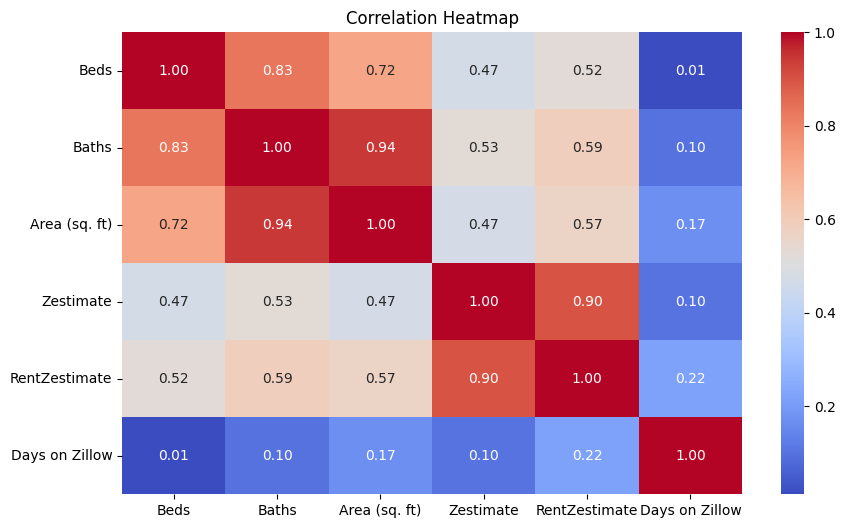

In [107]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def parse_zillow_results_from_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    try:
        zillow_data = json.loads(data)
        list_results = zillow_data['searchResults']['listResults']
        return list_results
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return []

def parse_zillow_properties(properties):
    parsed_properties = []
    for property_data in properties:
        parsed_property = {
            'ID': property_data.get('zpid', ''),
            'Property Type': property_data.get('statusText', ''),
            'Price': property_data.get('price', ''),
            'Address': property_data.get('addressStreet', ''),
            'City': property_data.get('addressCity', ''),
            'State': property_data.get('addressState', ''),
            'Zipcode': property_data.get('addressZipcode', ''),
            'Beds': property_data.get('beds', 0),
            'Baths': property_data.get('baths', 0),
            'Area (sq. ft)': property_data.get('area', 0),
            'Zestimate': property_data.get('hdpData', {}).get('homeInfo', {}).get('zestimate', 0),
            'RentZestimate': property_data.get('hdpData', {}).get('homeInfo', {}).get('rentZestimate', 0),
            'Days on Zillow': property_data.get('hdpData', {}).get('homeInfo', {}).get('daysOnZillow', 0),
            'Website': property_data.get('detailUrl',0)
        }
        parsed_properties.append(parsed_property)
    return parsed_properties

# Example usage:
file_path = 'zillow_sales_search_results.txt'
properties = parse_zillow_results_from_file(file_path)
parsed_properties = parse_zillow_properties(properties)

print('# Properties Parsed: ', len(parsed_properties))

# Create DataFrame
df = pd.DataFrame(parsed_properties)

# Convert numeric columns to integers
numeric_columns = ['Beds', 'Baths', 'Area (sq. ft)', 'Zestimate', 'RentZestimate', 'Days on Zillow']
for col in numeric_columns:
    df[col] = df[col].astype(int) # Convert to float
# Clean and convert 'price' column
df['Price'] = df['Price'].str.replace('[\$,]', '', regex=True)  # Remove '$' and ','
df['Price'] = df['Price'].str.replace('K', '000').str.replace('M', '000000')  # Replace 'K' and 'M' with zeros
df['Property Type'] = df['Property Type'].str.replace('for sale', '', regex=True)  # Remove '$' and ','

# Count the number of unique ZPID values
unique_zpids = df['ID'].nunique()
print('Number of unique ZPIDs:', unique_zpids)
print(df)


# Convert to numeric with coercion to handle non-numeric values
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert non-numeric values to NaN

# Drop non-numeric columns
numeric_df = df[numeric_columns]

#for col in df.columns:
#    unique_values = df[col].unique()
#    print(f"Unique values in {col}: {unique_values}")


# Perform data analysis and visualization here
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [78]:
import os

book = 'zillow_rental_search_p1.txt'
#book = 'zillow_rental_search_results.txt'

ZPID_Set = set()

with open(book, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if '"zpid"' in line:  # Ensure that only lines with proper ZPID information are considered
            parts = line.strip().split(':')
            if len(parts) >= 2: #This code snippet checks if the length of the list or string variable 'parts' is greater than or equal to 2. 
                ZPID = parts[1].strip().rstrip(',').replace('"', '')  # Extracting the value of ZPID from the line
                if ZPID not in ZPID_Set:  # Check if ZPID is already in the set
                    ZPID_Set.add(ZPID)  # Add ZPID to the set

print('Total Number of lines: ', len(lines))
print('Total number of unique ZPID: ', len(ZPID_Set))
print(ZPID_Set)


Total Number of lines:  8117
Total number of unique ZPID:  1
{'{encodedZuid'}


In [95]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import os


def fetch_page_content(url_or_filepath):
    # Check if the URL is a local file path
    if os.path.exists(url_or_filepath):
        # Open the local file and read its content
        with open(url_or_filepath, 'r') as file:
            content = file.read()
    else:
        # Fetch the page content using requests
        response = requests.get(url_or_filepath)
        content = response.content
    return content

def extract_rental_info(rental_element):
    rental = {}

    # Extract ZPID for each rental element
    rental['zpid'] = rental_element.find('article')['id'].split('_')[-1]

    # Extract Event Information
    event_script = rental_element.find('script', type='application/ld+json')
    if event_script:
        event_data = json.loads(event_script.text)
        event_location = event_data.get('location', [{}])[1].get('address', {})

        rental.update({
            'event_image': event_data.get('image', ''),
            'event_start_date': event_data.get('startDate', ''),
            'event_end_date': event_data.get('endDate', ''),
            'event_street_address': event_location.get('streetAddress', ''),
            'event_postal_code': event_location.get('postalCode', ''),
            'event_address_locality': event_location.get('addressLocality', ''),
            'event_address_region': event_location.get('addressRegion', '')
        })

    # Extract Property Details
    property_address_element = rental_element.find('address', {'data-test': 'property-card-addr'})
    rental['property_address'] = property_address_element.text.strip() if property_address_element else ''

    # Extract Prices
    price_elements = rental_element.find_all('span', {'class': 'PropertyCardWrapper__StyledPriceLine-srp__sc-16e8gqd-1.iMKTKr'})
    rental['prices'] = [elem.text.strip() for elem in price_elements] if price_elements else []

    # Extract Property Web URL
    property_web_url_element = rental_element.find('a', {'data-test': 'property-card-link'})
    rental['property_web_url'] = property_web_url_element['href'] if property_web_url_element else ''

    return rental

def parse_rentals_page(url_or_filepath):
    content = fetch_page_content(url_or_filepath)
    soup = BeautifulSoup(content, 'html.parser')

    rentals = []
    rental_elements = soup.find_all('div', {'data-renderstrat': 'ssr'})

    for rental_element in rental_elements:
        rental_info = extract_rental_info(rental_element)
        rentals.append(rental_info)

    return rentals

def extract_sales_info(sales_element):
    sale = {}

    # Extract ZPID for each sales element
    sale['zpid'] = sales_element.find('article')['id'].split('_')[-1]

    # Extract Property Details
    property_address_element = sales_element.find('address', {'data-address-label': 'property-address'})
    sale['property_address'] = property_address_element.text.strip() if property_address_element else ''

    # Extract Prices
    price_element = sales_element.find('span', {'class': 'Text-c11n-8-84-3__aiai24-0 iZVatD'})
    sale['price'] = price_element.text.strip() if price_element else ''

    # Extract Property Web URL
    property_web_url_element = sales_element.find('a', {'class': 'Anchor-c11n-8-84-3__sc-hn4bge-0 sc-ckEbSK kxrUt bnQEvw'})
    sale['property_web_url'] = property_web_url_element['href'] if property_web_url_element else ''

    return sale

def parse_sales_page(url_or_filepath):
    content = fetch_page_content(url_or_filepath)
    soup = BeautifulSoup(content, 'html.parser')

    sales = []
    sales_elements = soup.find_all('div', {'data-testid': 'home-card-sale'})

    for sales_element in sales_elements:
        sale_info = extract_sales_info(sales_element)
        sales.append(sale_info)

    return sales

def fetch_and_parse_data(base_url, parse_function, pages_to_fetch, file_path=None):
    all_data = []
    for page_number in range(1, pages_to_fetch + 1):
        if file_path:
            url_or_filepath = file_path
        else:
            url_or_filepath = f"{base_url}{page_number}_p/"
        data = parse_function(url_or_filepath)
        all_data.extend(data)
    return all_data

def parse_pagination_number(url):
    content = fetch_page_content(url)
    soup = BeautifulSoup(content, 'html.parser')
    pagination_elements = soup.find_all('a', {'class': 'StyledPaginationButton-c11n-8-84-3__aiai24-1'})
    if pagination_elements:
        last_page_number = max(int(page.text) for page in pagination_elements if page.text.isdigit())
        return last_page_number
    return 0  

def main():
    # Choose between online source or local file
    source_choice = input("Enter 'online' to use a website or 'local file' to use a file: ").lower()
    if source_choice not in ['online', 'local file']:
        print("Invalid choice.")
        return

    file_path = None  # Initialize file_path outside of the if block

    if source_choice == 'online':
        # Choose between rentals or sales
        choice = input("Enter 'rentals' or 'sales' to fetch data: ").lower()
        if choice not in ['rentals', 'sales']:
            print("Invalid choice.")
            return
        # Fetch the URL based on the choice
        if choice == 'rentals':
            base_url = "https://www.zillow.com/new-york-ny/rentals/"
        elif choice == 'sales':
            base_url = "https://www.zillow.com/new-york-ny/sales/"
        else:
            print("Invalid choice.")
            return
        # Get the number of pages to fetch
        pages_to_fetch = parse_pagination_number(base_url)
    else:  # Source choice is local file
        file_path = input("Enter the local file path: ")
        if not os.path.exists(file_path):
            print("File not found.")
            return
        # No need for pagination logic for local files
        pages_to_fetch = 1

    # Prompt for the pages to scrape
    pages_input = input("Enter 'all' to scrape all pages, 'range' to specify a range, or 'specific' for a specific page: ")
    if pages_input.lower() == 'all':
        pages_to_scrape = 'all'
    elif pages_input.lower() == 'range':
        start_page = int(input("Enter the start page: "))
        end_page = int(input("Enter the end page: "))
        pages_to_scrape = (start_page, end_page)
    elif pages_input.lower() == 'specific':
        specific_page = int(input("Enter the specific page: "))
        pages_to_scrape = (specific_page,)
    else:
        print("Invalid input for pages.")
        return
    
    print("Pages to Scrape:", pages_to_scrape)


    # Fetch and parse the data
    if choice == 'rentals':
        parse_function = parse_rentals_page
    elif choice == 'sales':
        parse_function = parse_sales_page

    all_data = fetch_and_parse_data(base_url, parse_function, pages_to_fetch, file_path)
    all_data_df = pd.DataFrame(all_data)
    if all_data_df.empty:
        print("No data found.")
        return
    unique_zpids_count = all_data_df['zpid'].nunique()
    

    print(f"\n{choice.capitalize()} DataFrame:")
    print(all_data_df)
    print(f"\nNumber of Unique {choice.capitalize()} ZPIDs:", unique_zpids_count)

if __name__ == "__main__":
    main()


No data found.
